In [1]:
%run ../../shared_setup.ipynb

docker image cggh/biipy:v1.6.0


In [2]:
gatk_raw = {cross: load_callset(GATK_CALLSET_FN_TEMPLATE.format(cross=cross))
            for cross in CROSSES}

2016-03-08 22:34:06.918871 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.gatk.final.npz
2016-03-08 22:34:06.969718 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/hb3_dd2.gatk.final.npz
2016-03-08 22:34:06.995866 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/7g8_gb4.gatk.final.npz


In [3]:
cortex_raw = {cross: load_callset(CORTEX_CALLSET_FN_TEMPLATE.format(cross=cross))
              for cross in CROSSES}

2016-03-08 22:34:07.055756 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.cortex.final.npz
2016-03-08 22:34:07.067733 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/hb3_dd2.cortex.final.npz
2016-03-08 22:34:07.085190 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/7g8_gb4.cortex.final.npz


In [4]:
gatk_query = '~FILTER_NON_SEGREGATING & ~FILTER_NON_CORE & ~FILTER_MISSING_PARENT & ~FILTER_DUP_SITE'
gatk_base = {cross: filter_variants(gatk_raw[cross], gatk_query)
             for cross in CROSSES}

cortex_query = """(
~FILTER_NON_SEGREGATING & ~FILTER_NON_CORE & ~FILTER_MISSING_PARENT & ~FILTER_DUP_SITE
& ~FILTER_MAPQ
& ~FILTER_MISMAPPED_UNPLACEABLE
& ~FILTER_MULTIALLELIC
& ~FILTER_OVERLAPPING_SITE
& ~FILTER_PF_FAIL_ERROR
& ~FILTER_PF_FAIL_REPEAT
& ~FILTER_DUP_ALLELE
)"""
cortex_base = {cross: filter_variants(cortex_raw[cross], cortex_query)
               for cross in CROSSES}

2016-03-08 22:34:08.813736 :: filter variants: excluding 132910 (69.3%) retaining 58976 (30.7%) of 191886 variants
2016-03-08 22:34:11.416873 :: filter variants: excluding 295256 (78.8%) retaining 79277 (21.2%) of 374533 variants
2016-03-08 22:34:14.462030 :: filter variants: excluding 310517 (80.5%) retaining 75250 (19.5%) of 385767 variants
2016-03-08 22:34:14.788571 :: filter variants: excluding 19668 (34.6%) retaining 37204 (65.4%) of 56872 variants
2016-03-08 22:34:15.428384 :: filter variants: excluding 72851 (68.4%) retaining 33714 (31.6%) of 106565 variants
2016-03-08 22:34:16.131715 :: filter variants: excluding 76820 (70.6%) retaining 31936 (29.4%) of 108756 variants


In [5]:
gatk_snp = {cross: filter_variants(gatk_base[cross], 'is_snp')
            for cross in CROSSES}
cortex_snp = {cross: filter_variants(cortex_base[cross], 'is_snp')
              for cross in CROSSES}

2016-03-08 22:34:16.159797 :: filter variants: excluding 32518 (55.1%) retaining 26458 (44.9%) of 58976 variants
2016-03-08 22:34:16.173375 :: filter variants: excluding 41203 (52.0%) retaining 38074 (48.0%) of 79277 variants
2016-03-08 22:34:16.195653 :: filter variants: excluding 39022 (51.9%) retaining 36228 (48.1%) of 75250 variants
2016-03-08 22:34:16.217177 :: filter variants: excluding 23191 (62.3%) retaining 14013 (37.7%) of 37204 variants
2016-03-08 22:34:16.224256 :: filter variants: excluding 19905 (59.0%) retaining 13809 (41.0%) of 33714 variants
2016-03-08 22:34:16.232156 :: filter variants: excluding 18871 (59.1%) retaining 13065 (40.9%) of 31936 variants


In [6]:
gatk_indel = {cross: filter_variants(gatk_base[cross], '~is_snp')
              for cross in CROSSES}
cortex_indel = {cross: filter_variants(cortex_base[cross], '~is_snp')
                for cross in CROSSES}

2016-03-08 22:34:16.283432 :: filter variants: excluding 26458 (44.9%) retaining 32518 (55.1%) of 58976 variants
2016-03-08 22:34:16.300477 :: filter variants: excluding 38074 (48.0%) retaining 41203 (52.0%) of 79277 variants
2016-03-08 22:34:16.330337 :: filter variants: excluding 36228 (48.1%) retaining 39022 (51.9%) of 75250 variants
2016-03-08 22:34:16.363120 :: filter variants: excluding 14013 (37.7%) retaining 23191 (62.3%) of 37204 variants
2016-03-08 22:34:16.377761 :: filter variants: excluding 13809 (41.0%) retaining 19905 (59.0%) of 33714 variants
2016-03-08 22:34:16.393172 :: filter variants: excluding 13065 (40.9%) retaining 18871 (59.1%) of 31936 variants


In [7]:
GATK_MIN_VQSLOD_SNP = {
    '3d7_hb3': 2.5, 'hb3_dd2': 3., '7g8_gb4': 4.
}
GATK_MIN_VQSLOD_INDEL = {
    '3d7_hb3': 1., 'hb3_dd2': 1.5, '7g8_gb4': 1.8
}

CORTEX_MIN_SITE_CONF_SNP = {
    '3d7_hb3': 50, 'hb3_dd2': 50, '7g8_gb4': 50
}
CORTEX_MIN_SITE_CONF_INDEL = {
    '3d7_hb3': 200, 'hb3_dd2': 200, '7g8_gb4': 200
}

In [8]:
def plot_me_roc(ax, callset, variant_thresholds, call_thresholds, variant_field, call_field):
    
    # iterate over call thresholds
    for min_call_q, color in zip(call_thresholds, 'bgrcmyk'):
        
        # first filter the genotype calls
        callset_cflt = filter_calls(callset, '%s >= %s' % (call_field, min_call_q), verbose=False)
        
        # now filter variants where the parent call is missing or filtered (so cannot determine Mendelian status)
        pconf = lambda v, c, c2d: np.all(c2d.genotype[:, :2] >= 0, axis=1) & np.any(c2d.genotype > 0, axis=1)
        callset_pconf = filter_variants(callset_cflt, pconf, verbose=False)
        
        # setup output arrays
        x = list()
        y = list()
        z = list()
        
        # iterate over variant thresholds
        for min_variant_q in variant_thresholds:
            
            # filter the variants
            vflt = lambda v, c, c2d: v[variant_field] >= min_variant_q
            callset_vflt = filter_variants(callset_pconf, vflt, verbose=False)
            
            # unpack the callset
            v, c, c2d = unpack_callset(callset_vflt)
            
            # compute inheritance
            p = inheritance(c2d.genotype)
            
            # count calls
            n_variants, n_samples = p.shape
            n_calls = np.count_nonzero(p != INHERITANCE_MISSING)
            n_calls_err = np.count_nonzero(p == INHERITANCE_NONPARENTAL)
            # use number of non-missing calls as denominator
            pc_calls_err = n_calls_err * 100 / n_calls
            n_variants_err = np.count_nonzero(np.any(p == INHERITANCE_NONPARENTAL, axis=1))
            pc_variants_err = n_variants_err * 100 / n_variants
            x.append(n_variants)
            y.append(pc_variants_err)
            z.append(pc_calls_err)
            
        # plot line
        ax.plot(x, z, marker='o', linestyle='-', lw=1, color=color, label='(%s >= %s)' % (call_field, min_call_q))
        
        # annotate points
        for _x, _z, min_variant_q in zip(x, z, variant_thresholds):
            if _z < .2:
                ax.annotate(str(min_variant_q), xy=(_x, _z), xytext=(0, 0), xycoords='data', textcoords='offset points',
                            ha='center', va='center', fontsize=5,
                            bbox=dict(facecolor='white', alpha=1, edgecolor=color, linewidth=.5), 
                            arrowprops=dict(color='gray', arrowstyle='-', shrinkA=0, shrinkB=0))

    ax.set_xlabel('number of segregating variants')
    ax.set_ylabel('% non-mendelian calls')
    ax.grid(axis='y')            
    

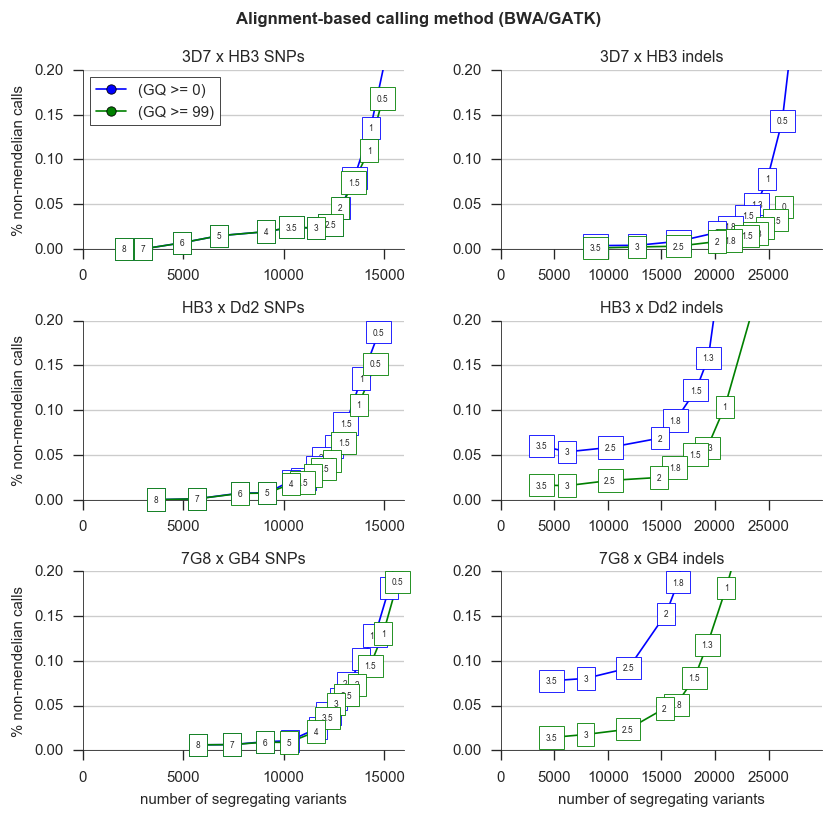

In [9]:
fig = plt.figure(figsize=(7, 7))
snp_vqslod_thresholds = .5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7, 8
indel_vqslod_thresholds = 0, .5, 1, 1.3, 1.5, 1.8, 2, 2.5, 3, 3.5
gq_thresholds = 0, 99

for i, cross in enumerate(CROSSES):
    
    callset = gatk_snp[cross]
    ax = fig.add_subplot(3, 2, 2*i+1)
    sns.despine(ax=ax)
    plot_me_roc(ax, callset, 
                variant_thresholds=snp_vqslod_thresholds, call_thresholds=gq_thresholds,
                variant_field='VQSLOD', call_field='GQ')
    ax.set_title('%s SNPs' % LABELS[cross])
    ax.set_xlim(0, 16000)
    ax.set_xticks(range(0, 16000, 5000))
    ax.set_ylim(0, .2)
    if i < 2:
        ax.set_xlabel('')
    if i == 0:
        ax.legend(loc='upper left', frameon=True)
#     ax.legend(fontsize=8)
    
    callset = gatk_indel[cross]
    ax = fig.add_subplot(3, 2, 2*i+2)
    sns.despine(ax=ax)
    plot_me_roc(ax, callset, 
                variant_thresholds=indel_vqslod_thresholds, call_thresholds=gq_thresholds,
                variant_field='VQSLOD', call_field='GQ')
    ax.set_title('%s indels' % LABELS[cross])
    ax.set_xlim(0, 30000)
    ax.set_xticks(range(0, 30000, 5000))
    ax.set_ylim(0, .2)
    if i < 2:
        ax.set_xlabel('')
    ax.set_ylabel('')
    
#     ax.legend(fontsize=8)
    
fig.suptitle('Alignment-based calling method (BWA/GATK)', fontsize=10, fontweight='bold')
#fig.tight_layout()
fig.subplots_adjust(hspace=.4, wspace=.3, top=.91, left=.1, right=.98, bottom=.1)

fn = '../../artwork/supp/callset_calibration_gatk.{dpi}.{fmt}'
for fmt in 'jpeg', 'png':
    for dpi in 120, 300:
        fig.savefig(fn.format(dpi=dpi, fmt=fmt), dpi=dpi, jpeg_quality=100)


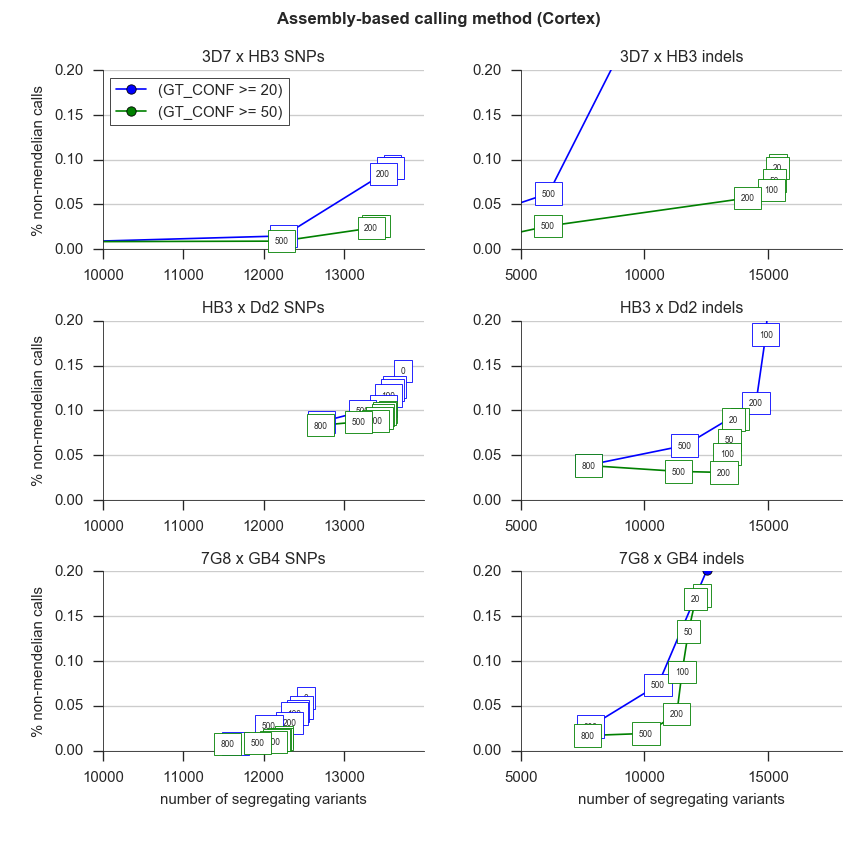

In [10]:
fig = plt.figure(figsize=(7, 7))
site_conf_thresholds = 0, 20, 50, 100, 200, 500, 800
gt_conf_thresholds = 20, 50

for i, cross in enumerate(CROSSES):
    
    callset = cortex_snp[cross]
    ax = fig.add_subplot(3, 2, 2*i+1)
    sns.despine(ax=ax)
    plot_me_roc(ax, callset, 
                variant_thresholds=site_conf_thresholds, call_thresholds=gt_conf_thresholds,
                variant_field='SITE_CONF', call_field='GT_CONF')
    ax.set_title('%s SNPs' % LABELS[cross])
    ax.set_xlim(10000, 14000)
    ax.set_xticks(range(10000, 14000, 1000))
    ax.set_ylim(0, .2)
    if i == 0:
        ax.legend(loc='upper left', frameon=True)
    if i < 2:
        ax.set_xlabel('')
#     ax.legend(fontsize=8)
    
    callset = cortex_indel[cross]
    ax = fig.add_subplot(3, 2, 2*i+2)
    sns.despine(ax=ax)
    plot_me_roc(ax, callset, 
                variant_thresholds=site_conf_thresholds, call_thresholds=gt_conf_thresholds,
                variant_field='SITE_CONF', call_field='GT_CONF')
    ax.set_title('%s indels' % LABELS[cross])
    ax.set_xlim(5000, 18000)
    ax.set_xticks(range(5000, 18000, 5000))
    ax.set_ylim(0, .2)
    if i < 2:
        ax.set_xlabel('')
    ax.set_ylabel('')
#     ax.legend(fontsize=8)
    
fig.suptitle('Assembly-based calling method (Cortex)', fontsize=10, fontweight='bold')
#fig.tight_layout()
fig.subplots_adjust(hspace=.4, wspace=.3, top=.91, left=.1, right=.98, bottom=.1)

fn = '../../artwork/supp/callset_calibration_cortex.{dpi}.{fmt}'
for fmt in 'jpeg', 'png':
    for dpi in 120, 300:
        fig.savefig(fn.format(dpi=dpi, fmt=fmt), dpi=dpi, jpeg_quality=100)
